# **Incremental learning**

In [0]:
import os

In [0]:
if not os.path.isdir("./project_IL"):
  !git clone https://github.com/frattinfabio/project_IL.git

Cloning into 'project_IL'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 371 (delta 108), reused 0 (delta 0), pack-reused 183
Receiving objects: 100% (371/371), 233.84 KiB | 11.13 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [0]:
from project_IL.model.IncrementalLearner import IncrementalLearner
from project_IL.params import get_params
from project_IL.data_handler.data_utils import load_data
from project_IL.classifiers.classifiers_utils import evaluate_incremental

## **Defining parameters**

In [0]:
NUM_CLASSES = 100
NUM_GROUPS = 10
CLASSES_PER_GROUP = NUM_CLASSES // NUM_GROUPS
SPLITTING_SEED = 15
APPROACH = "ICARL" # possible values: ["FINETUNING", "LWF", "ICARL", "VARIATION"]

In [0]:
# get the pre-defined params according to the decided approach
# modify those params for a different learning behaviour
# ex: modify approach_params["distillation_loss"] for a different distillation behaviour
train_params, approach_params = get_params(APPROACH) 

## **Main module**

In [0]:
il = IncrementalLearner(NUM_CLASSES, NUM_GROUPS, SPLITTING_SEED, approach_params, train_params)
classifier = approach_params["classifier"]

new_classes_accuracies = []
old_classes_accuracies = []
overall_accuracies = []

In [0]:
for _ in range(il.num_groups):

  il.step()
  train_dataloader, new_test_dataloader, old_test_dataloader = load_data(il.current_step, il.splitter.labels_split, il.train_params, il.exemplars)
  il.update_nets()
  if approach_params["use_variation"] and il.current_step > 0:
    train_dataloader_no_exemplars, _, _ = load_data(il.current_step, il.splitter.labels_split, il.train_params, None)
    il.train_ft(train_dataloader_no_exemplars)
  il.train(train_dataloader)
  classifier.update(il.current_step, il.net, train_dataloader)
  if approach_params["use_exemplars"]:
    il.update_exemplars()

  print("Classifying...")
  accuracies = evaluate_incremental(new_test_dataloader, old_test_dataloader, classifier)
  new_classes_accuracies.append(accuracies["new"])
  old_classes_accuracies.append(accuracies["old"])
  overall_accuracies.append(accuracies["overall"])
  print(f"Accuracies after having learned {il.n_known_classes} classes:")
  print(f"- current:\t{accuracies['new']:.3f}")
  if il.current_step > 0:
    print(f"- old:\t{accuracies['old']:.3f}")
    print(f"- overall:\t{accuracies['overall']:.3f}")
  print("")

Training the main net...
Epoch 70/70...
Updating exemplars...
Classifying...
Accuracies after having learned 10 classes:
- current:	0.867

Adding exemplars to the training dataset...
Updating networks...
Training the main net...
Epoch 70/70...
Updating exemplars...
Classifying...
Accuracies after having learned 20 classes:
- current:	0.674
- old:	0.798
- overall:	0.736

Adding exemplars to the training dataset...
Updating networks...
Training the main net...
Epoch 70/70...
Updating exemplars...
Classifying...
Accuracies after having learned 30 classes:
- current:	0.677
- old:	0.685
- overall:	0.682

Adding exemplars to the training dataset...
Updating networks...
Training the main net...
Epoch 70/70...
Updating exemplars...
Classifying...
Accuracies after having learned 40 classes:
- current:	0.662
- old:	0.617
- overall:	0.628

Adding exemplars to the training dataset...
Updating networks...
Training the main net...
Epoch 70/70...
Updating exemplars...
Classifying...
Accuracies after 

## **Results visualization**




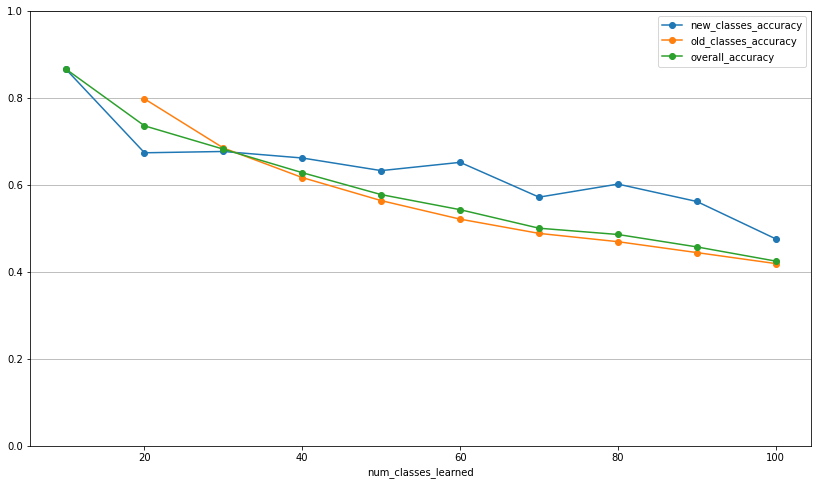

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(
    data = zip(range(10,100+10,10), new_classes_accuracies, old_classes_accuracies, overall_accuracies),
    columns = ["num_classes_learned", "new_classes_accuracy", "old_classes_accuracy", "overall_accuracy"])
results_df.set_index("num_classes_learned")

results_df.plot(x = "num_classes_learned", marker = 'o', figsize = (14,8))
plt.ylim(0,1)
plt.grid(True, axis = 'y')

In [0]:
results_df.to_csv("./accuracy_results.csv", index = False)

In [0]:
def get_predictions(classifier, test_dataloader): 
  predictions = []
  ground_truth = []
  for images, labels in test_dataloader:
    images = images.cuda()
    labels = labels.cuda()
    preds = classifier.classify(images)
    for label, pred in zip(labels.data, preds):
      ground_truth.append(label.item())
      predictions.append(pred.item())

  return ground_truth, predictions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(96.0, 0.5, 'True Class')

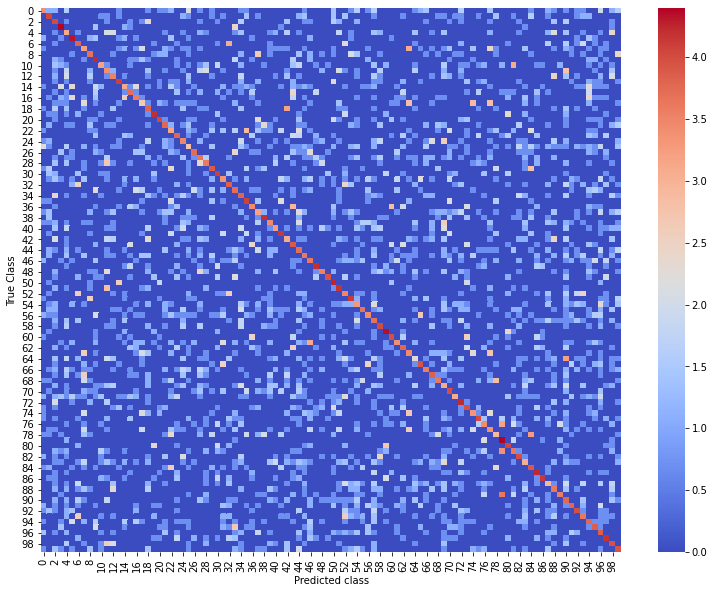

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from project_IL.data_handler.SubCIFAR import SubCIFAR
from torch.utils.data import DataLoader
import numpy as np

full_test_dataset = SubCIFAR(labels_split = il.splitter.labels_split, labels = list(range(NUM_CLASSES)), train = False, transform = train_params["test_transform"])
full_test_dataloader =  DataLoader(full_test_dataset, batch_size = train_params["BATCH_SIZE"], num_workers = 4)
truth, pred = get_predictions(classifier, full_test_dataloader)
conf = confusion_matrix(truth, pred)

fig, ax = plt.subplots(figsize = (13,10))
sns.heatmap(np.log(conf+1), cmap="coolwarm", ax = ax)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True Class")

In [0]:
np.savetxt("preds.csv", pred, delimiter = ",")

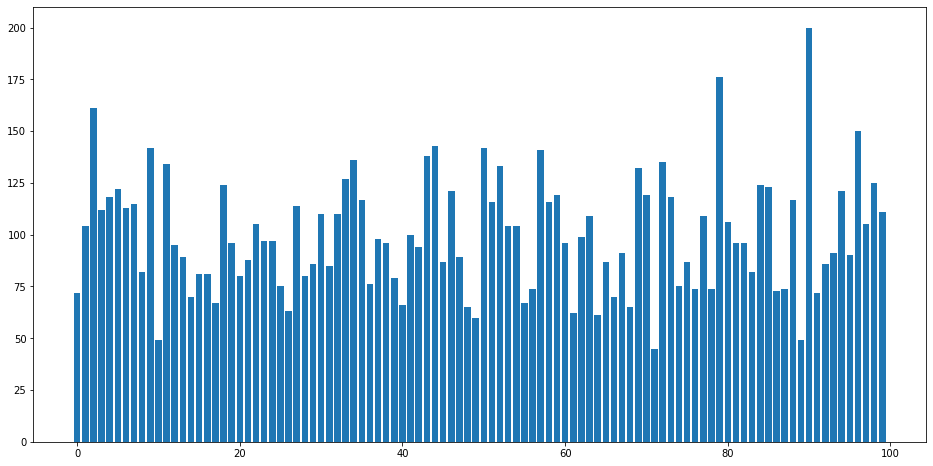

In [0]:
fig, ax = plt.subplots(figsize = (16, 8))
labels, counts = np.unique(pred, return_counts=True)
plt.bar(labels, counts, align='center')
plt.show()

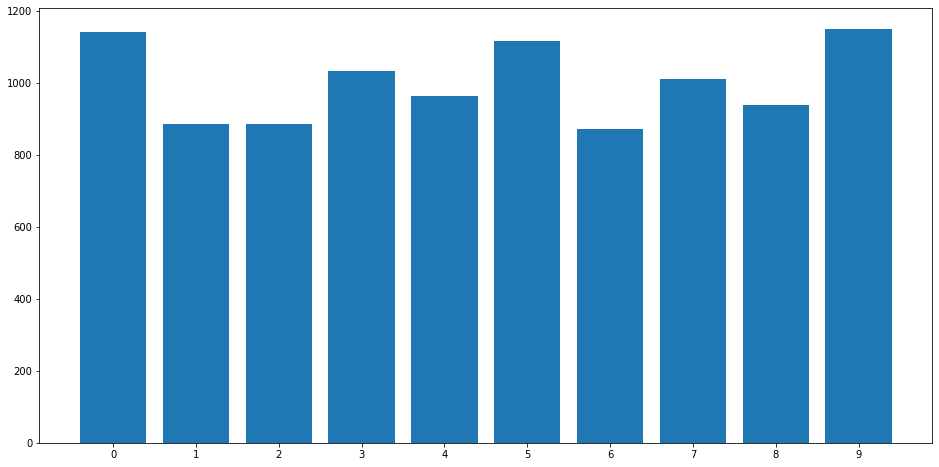

In [0]:
import math

group_pred = [math.floor(p/CLASSES_PER_GROUP) for p in pred]
# plotting the histogram of the number of predictions for the various classes
fig, ax = plt.subplots(figsize = (16, 8))
labels, counts = np.unique(group_pred, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [0]:
from sklearn.metrics import classification_report
report = classification_report(truth, pred, zero_division = 0, output_dict = True)
report_df = pd.DataFrame(report).transpose()

In [0]:
report_df.to_csv("./classification_report.csv", index = False)